## Raspberry Shake: detection statistics

Using the waveform data recorded by a Raspberry Shake seismograph (single station), earthquake events were classified as either detected or not detected. With these detection statistics, a logistic regression is fit to determine the empirical sensitivity of the seismograph. The results were then compared to the manufacturer's specifications.

### Dataset

The dataset included events for: global earthquake above about a magnitude Mw 6, regional earthquakes above about M4, and local earthquake down to about M 1. For each event, the section of the waveform corresponding to the P-wave arrival was viewed and the event recorded as either a detection or non-detection.

In [2]:
# Read in the data (csv file saved locally)

import pandas as pd
import numpy as np

df = pd.read_csv('/home/nicole/seismology/model/data_1105.csv')
print('Total number of earthquake events:', df.index.max())
df.head(10)

Total number of earthquake events: 394


,time,deg,depth,mag_mw,detection
0,2017-06-10T05:42:14.370Z,105.952703,10.00,5.600,0
1,2017-06-10T11:08:58.360Z,33.804036,15.00,4.685,0
2,2017-06-10T18:47:31.060Z,43.068157,10.00,5.500,1
3,2017-06-10T20:38:18.560Z,4.573277,10.00,4.800,1
4,2017-06-11T12:19:29.750Z,8.725221,22.86,3.530,0
5,2017-06-11T23:15:06.180Z,121.785356,7.00,5.600,0
6,2017-06-12T02:43:26.880Z,93.128312,27.00,5.700,0
7,2017-06-12T12:28:39.070Z,87.350142,12.00,6.300,1
8,2017-06-12T15:06:26.640Z,39.105666,16.07,5.365,0
9,2017-06-12T22:54:55.650Z,9.548835,10.56,3.160,0


In [3]:
# Make some plots - what are we trying to fit?

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(font_scale=1.5)

from pylab import rcParams
# Set the figure size
rcParams['figure.figsize'] = 12, 8

In [4]:
# Separate out each series for easier plotting
yes_deg = df[df['detection']==1]['deg']
yes_mag = df[df['detection']==1]['mag_mw']
no_deg = df[df['detection']==0]['deg']
no_mag = df[df['detection']==0]['mag_mw']

# Change the variables so that the data can be separated by a linear boundary

# Try the log of the distance (earthquake energy decreases with the square of the distance)
df['log_deg'] = np.log10(df['deg'])

# Separate out the corresponding series
yes_ldeg = df[df['detection']==1]['log_deg']
no_ldeg = df[df['detection']==0]['log_deg']

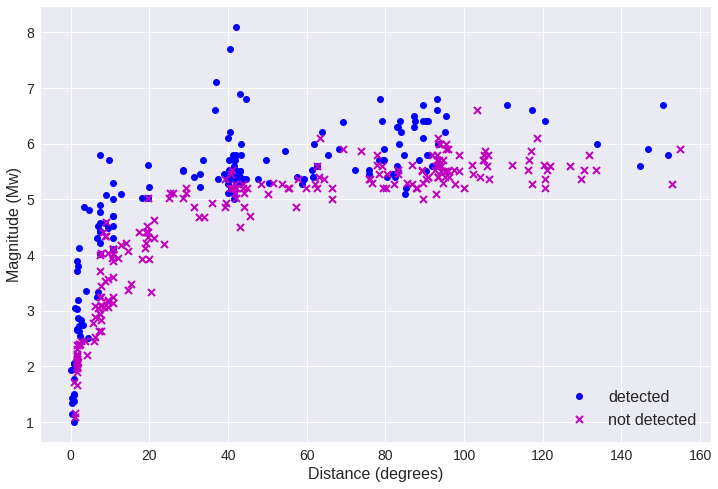

In [5]:
# Plot the data
fig, ax = plt.subplots(1, 1)
ax.plot(yes_deg, yes_mag, 'bo', label='detected')
ax.plot(no_deg, no_mag, 'mx', mew=2, label='not detected')
ax.set_xlabel('Distance (degrees)', fontsize='16')
ax.set_ylabel('Magnitude (Mw)', fontsize='16')
ax.legend(fontsize='16', loc=4)
ax.tick_params(labelsize='14')

#plt.savefig('model_rawdata.png', dpi=300)

In [6]:
# Split into training and testing sets

from sklearn.model_selection import train_test_split

feature_cols = ['mag_mw', 'log_deg']
X = df[feature_cols]
y = df.detection

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=87)

print(X.shape, y.shape)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(395, 2) (395,)
(316, 2) (316,)
(79, 2) (79,)


In [7]:
# fit a logistic regression model

from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=10)
feature_cols = ['mag_mw', 'log_deg']
X = df[feature_cols]
y = df.detection
logreg.fit(X_train, y_train)

print('The intercept is: ', logreg.intercept_)
print('The coefficients are (mag, log_deg): ', logreg.coef_)
print('The score is (test data, no CV): ', logreg.score(X_test,y_test))

The intercept is:  [-5.90960251]
The coefficients are (mag, log_deg):  [[ 3.06491157 -6.29168103]]
The score is (test data, no CV):  0.848101265823


In [8]:
from sklearn.model_selection import cross_val_score
clf = LogisticRegression(C=10)
scores = cross_val_score(clf, X, y, cv=5)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.80 (+/- 0.06)


In [9]:
# Create the arrays of numbers for plotting
beta0 = logreg.intercept_
beta1, beta2 = logreg.coef_[0]

m = -beta2/beta1

b25 = (np.log(0.25/(1-0.25)) - beta0)/beta1
b50 = (np.log(0.50/(1-0.50)) - beta0)/beta1
b75 = (np.log(0.75/(1-0.75)) - beta0)/beta1

xx = np.linspace(-1, 2.4)

yy25 = m*xx + b25
yy50 = m*xx + b50
yy75 = m*xx + b75

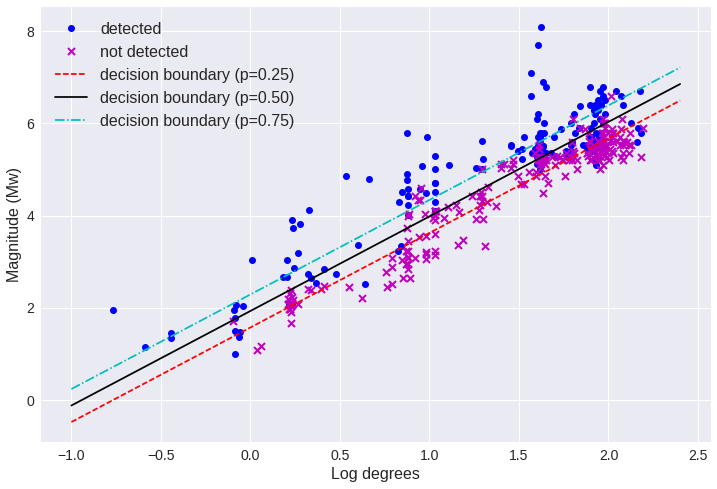

In [10]:
# Plot with the decision boundaries
fig, ax = plt.subplots(1, 1)
ax.plot(yes_ldeg, yes_mag, 'bo', label='detected')
ax.plot(no_ldeg, no_mag, 'mx', mew=2, label='not detected')

ax.plot(xx, yy25, 'r--', label='decision boundary (p=0.25)')
ax.plot(xx, yy50, 'k', label='decision boundary (p=0.50)')
ax.plot(xx, yy75, 'c-.', label='decision boundary (p=0.75)')

ax.set_xlabel('Log degrees', fontsize='16')
ax.set_ylabel('Magnitude (Mw)', fontsize='16')
ax.tick_params(labelsize='14')
ax.legend(fontsize='16')

plt.savefig('model_decision_straight.png', dpi=300)

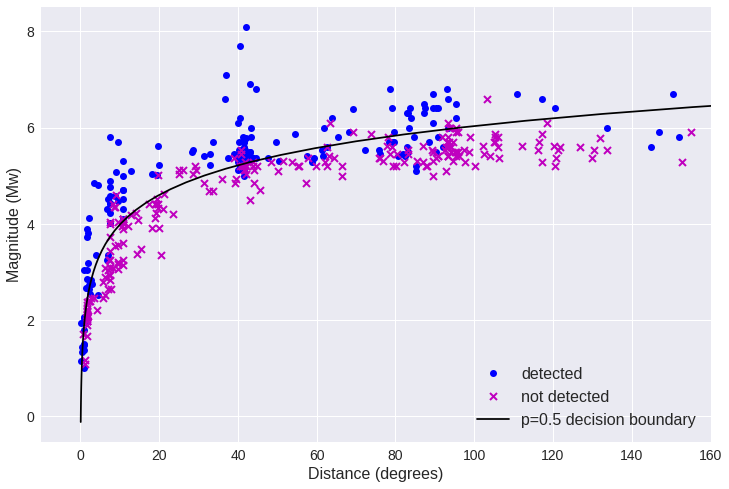

In [11]:
# Convert the x-values from log-degrees to degrees 
# from the docs: "First array elements raised to powers from second array, element-wise."
xx_log10 = np.power(10, xx)

fig, ax = plt.subplots(1, 1)
ax.plot(yes_deg, yes_mag, 'bo', label='detected')
ax.plot(no_deg, no_mag, 'mx', mew=2, label='not detected')
ax.plot(xx_log10, yy50, 'k', label='p=0.5 decision boundary')

ax.set_xlabel('Distance (degrees)', fontsize='16')
ax.set_ylabel('Magnitude (Mw)', fontsize='16')
ax.tick_params(labelsize='14')

ax.set_xlim([-10,160])
ax.legend(fontsize='16', loc=4)

plt.savefig('model_decision_curve.png', dpi=300)

In [12]:
# Calculate the model prediction for the Quest Shake
# 95% confidence

b95 = (np.log(0.95/(1-0.95)) - beta0)/beta1

mag_p = 2
deg_p_log = (mag_p-b95)/m

deg_p = np.power(10,deg_p_log)

print('Distance in degrees for 95% confidence:', deg_p)

Distance in degrees for 95% confidence: [ 0.36898834]


In [13]:
xx_p = np.linspace(-1, 2.4)

temp4 = -1*(beta0+(beta1*4)+(beta2*xx_p))
temp2 = -1*(beta0+(beta1*2)+(beta2*xx_p))

e_vec4 = np.exp(temp4)
p_vec4 = 1/(1+e_vec4)

e_vec2 = np.exp(temp2)
p_vec2 = 1/(1+e_vec2)

# Convert xx_p into km
from obspy.geodetics import degrees2kilometers
ans = degrees2kilometers(0.36898834)

deg_temp = np.power(10, xx_p)
xx_p_km = degrees2kilometers(deg_temp)


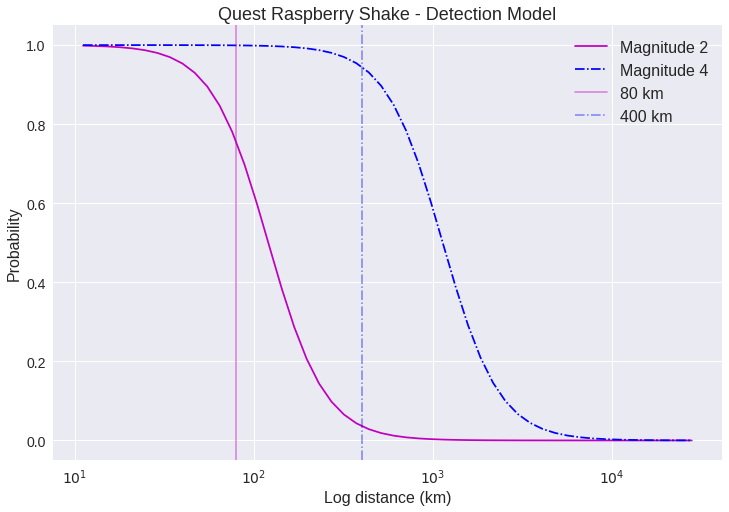

In [14]:
# Plot the detection model
fig, ax = plt.subplots(1, 1)

ax.plot(xx_p_km, p_vec2, 'm', label='Magnitude 2')
ax.plot(xx_p_km, p_vec4, 'b-.', label='Magnitude 4')

plt.axvline(x=80, color='m', label='80 km', alpha=0.4)
plt.axvline(x=400, color='b',linestyle='-.', label='400 km', alpha=0.4)

ax.set_xscale('log')
ax.set_xlabel('Log distance (km)', fontsize='16')
ax.set_ylabel('Probability', fontsize='16')
ax.tick_params(labelsize='14')

ax.set_title('Quest Raspberry Shake - Detection Model')
ax.legend(fontsize='16', loc=0)

plt.savefig('model_decision_pvec.png', dpi=300)